In [1]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

/tmp/ipython-input-1789620449.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2023-01-01")
[*********************100%***********************]  1 of 1 completed


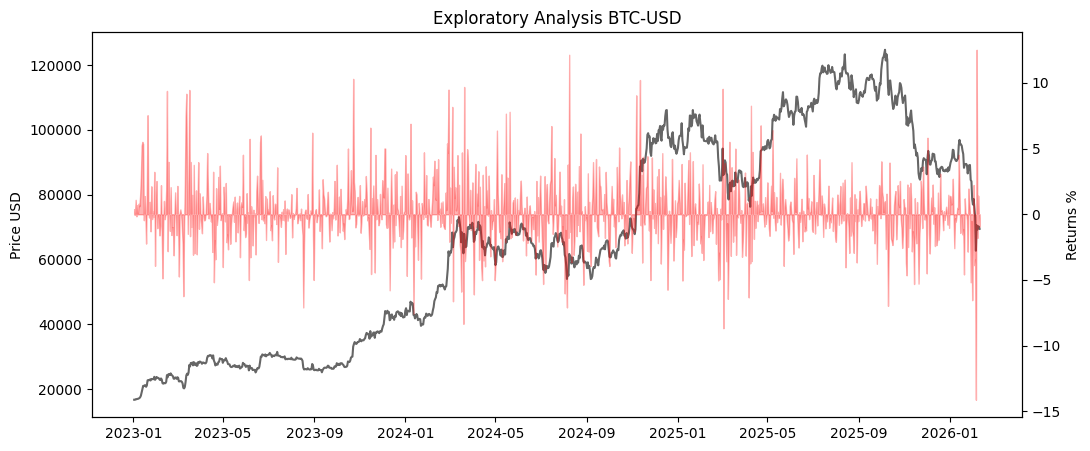

In [3]:
# 1. Download data
ticker = "BTC-USD"
df = yf.download(ticker, start="2023-01-01")
df['Returns'] = 100 * df['Close'].pct_change().dropna()
df['RV'] = df['Returns'].abs() # Proxy for daily volatility
df = df.dropna()

# Plot Block 1: Prices and Returns
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(df['Close'], color='black', label='BTC Price', alpha=0.6)
ax1.set_ylabel('Price USD')
ax2 = ax1.twinx()
ax2.fill_between(df.index, df['Returns'], color='red', alpha=0.3, label='Returns %')
ax2.set_ylabel('Returns %')
plt.title(f"Exploratory Analysis {ticker}")
plt.show()

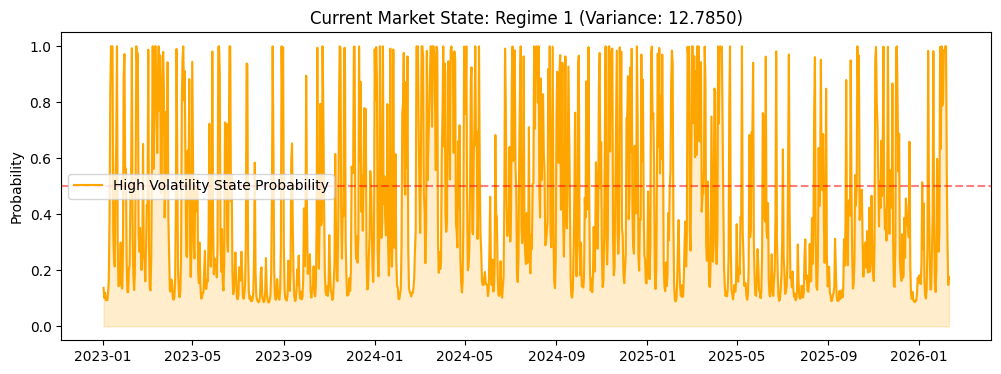

Calm Regime Variance: 1.4836
Stress Regime Variance: 12.7850
Current probability of being in stress regime: 17.53%


In [4]:
# 2. 2-State Markov Switching Model
# Set frequency to avoid warnings
df.index.freq = 'D'

# Model fitting
# switching_variance=True allows each regime to have its own variance
model_ms = MarkovRegression(df['Returns'], k_regimes=2, switching_variance=True)
res_ms = model_ms.fit()

# ATTRIBUTEERROR FIX:
# Look for variance parameters (sigma2) in the .params vector
# In statsmodels, these are labeled as sigma2[0], sigma2[1], etc.
vols = [res_ms.params[f'sigma2[{i}]'] for i in range(2)]
high_vol_regime = np.argmax(vols)

# Extract probabilities
df['Prob_High_Vol'] = res_ms.smoothed_marginal_probabilities[high_vol_regime]

# Plot Block 2: Regime Probabilities
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Prob_High_Vol'], color='orange', label='High Volatility State Probability')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5)
plt.fill_between(df.index, df['Prob_High_Vol'], color='orange', alpha=0.2)
plt.title(f"Current Market State: Regime {high_vol_regime} (Variance: {vols[high_vol_regime]:.4f})")
plt.ylabel("Probability")
plt.legend()
plt.show()

print(f"Calm Regime Variance: {min(vols):.4f}")
print(f"Stress Regime Variance: {max(vols):.4f}")
print(f"Current probability of being in stress regime: {df['Prob_High_Vol'].iloc[-1]:.2%}")

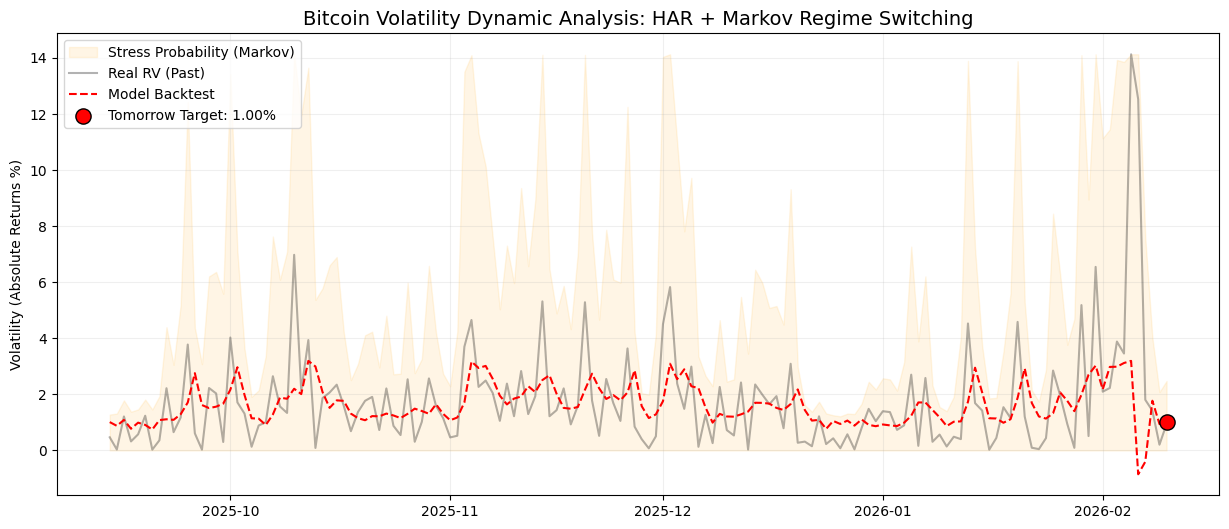

      BTC INTEGRATED REPORT
Current State (Stress Prob.): 17.53%
Tomorrow Volatility Forecast: 1.0000%
-----------------------------------
Model Coefficients:
const             0.665735
(RV_D, )         -0.377544
(RV_W, )         -0.101029
(RV_M, )          0.103566
(Regime_Lag, )    4.080441
dtype: float64


In [5]:
# --- INTEGRATED PREDICTIVE MODEL (CORRECTED & OPTIMIZED) ---

# 1. Component Preparation (Inertia and Regime)
df['RV_D'] = df['RV'].shift(1)
df['RV_W'] = df['RV'].rolling(window=5).mean().shift(1)
df['RV_M'] = df['RV'].rolling(window=22).mean().shift(1)
# Regime_Lag: yesterday's probability helps explain today's volatility
df['Regime_Lag'] = df['Prob_High_Vol'].shift(1)

# Data cleaning for fitting (removing initial null values)
df_reg = df[['RV', 'RV_D', 'RV_W', 'RV_M', 'Regime_Lag']].dropna()

# 2. Integrated OLS Regression
X_train = sm.add_constant(df_reg[['RV_D', 'RV_W', 'RV_M', 'Regime_Lag']])
y_train = df_reg['RV']
model_integrated = sm.OLS(y_train, X_train).fit()

# 3. Generating Historical Forecasts (Backtest)
X_full = sm.add_constant(df[['RV_D', 'RV_W', 'RV_M', 'Regime_Lag']])
df['Forecast_Integrated'] = model_integrated.predict(X_full)

# 4. Calculation of Tomorrow's Prediction
current_prob = df['Prob_High_Vol'].iloc[-1]
# Load TODAY'S data to predict TOMORROW (no shift here)
last_features = [1, df['RV'].iloc[-1], df['RV'].rolling(5).mean().iloc[-1],
                 df['RV'].rolling(22).mean().iloc[-1], current_prob]
pred_tomorrow = model_integrated.predict([last_features])[0]

# 5. Full Visualization
plt.figure(figsize=(15, 6))

# Markovian Stress Area in the background
plt.fill_between(df.index[-150:], 0, df['Prob_High_Vol'].iloc[-150:] * df['RV'].max(),
                 color='orange', alpha=0.1, label='Stress Probability (Markov)')

# Real Data vs. Past Forecasts
plt.plot(df.index[-150:], df['RV'].iloc[-150:], color='black', alpha=0.3, label='Real RV (Past)')
plt.plot(df.index[-150:], df['Forecast_Integrated'].iloc[-150:], color='red', linewidth=1.5,
         linestyle='--', label='Model Backtest')

# THE TARGET: Tomorrow's forecast positioned on the last date
plt.scatter(df.index[-1], pred_tomorrow, color='red', s=120, edgecolors='black',
            label=f'Tomorrow Target: {pred_tomorrow:.2f}%', zorder=5)

plt.title("Bitcoin Volatility Dynamic Analysis: HAR + Markov Regime Switching", fontsize=14)
plt.ylabel("Volatility (Absolute Returns %)")
plt.legend(loc='upper left')
plt.grid(alpha=0.2)
plt.show()

# 6. Text Report
print(f"{'='*35}")
print(f"      BTC INTEGRATED REPORT")
print(f"{'='*35}")
print(f"Current State (Stress Prob.): {current_prob:.2%}")
print(f"Tomorrow Volatility Forecast: {pred_tomorrow:.4f}%")
print(f"{'-'*35}")
print(f"Model Coefficients:")
print(model_integrated.params)
print(f"{'='*35}")

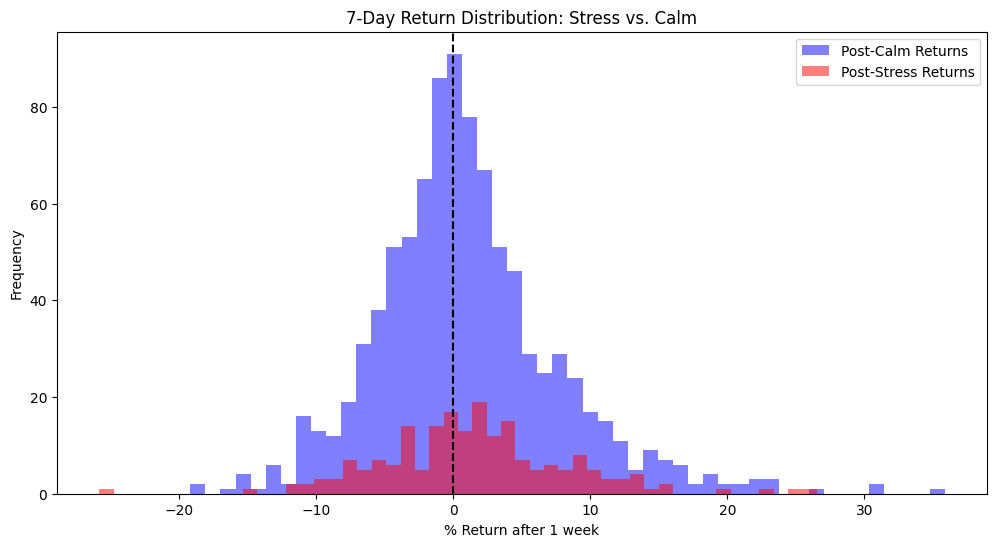

--- HISTORICAL ANALYSIS OF STRESS SIGNALS ---
Average return in Stress regime: 1.59%
Average return in Calm regime: 0.99%
Return volatility (Std.Dev.) in Stress: 6.98%


In [6]:
# 1. Identify "Stress Signal" moments (like the current one)
# Signal if Prob_High_Vol > 0.8 (since you are currently at 88%)
df['Signal'] = (df['Prob_High_Vol'] > 0.8).astype(int)

# 2. Analyze 7-day returns following the signal
df['Returns_7D'] = df['Close'].pct_change(7).shift(-7) * 100

# 3. Separate periods: Stress vs. Calm
stress_periods = df[df['Signal'] == 1]['Returns_7D'].dropna()
calm_periods = df[df['Signal'] == 0]['Returns_7D'].dropna()

# 4. Backtest Visualization
plt.figure(figsize=(12, 6))
plt.hist(calm_periods, bins=50, alpha=0.5, label='Post-Calm Returns', color='blue')
plt.hist(stress_periods, bins=50, alpha=0.5, label='Post-Stress Returns', color='red')
plt.axvline(0, color='black', linestyle='--')
plt.title("7-Day Return Distribution: Stress vs. Calm")
plt.xlabel("% Return after 1 week")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Comparison statistics
print(f"--- HISTORICAL ANALYSIS OF STRESS SIGNALS ---")
print(f"Average return in Stress regime: {stress_periods.mean():.2f}%")
print(f"Average return in Calm regime: {calm_periods.mean():.2f}%")
print(f"Return volatility (Std.Dev.) in Stress: {stress_periods.std():.2f}%")

In [7]:
from scipy.stats import t, norm

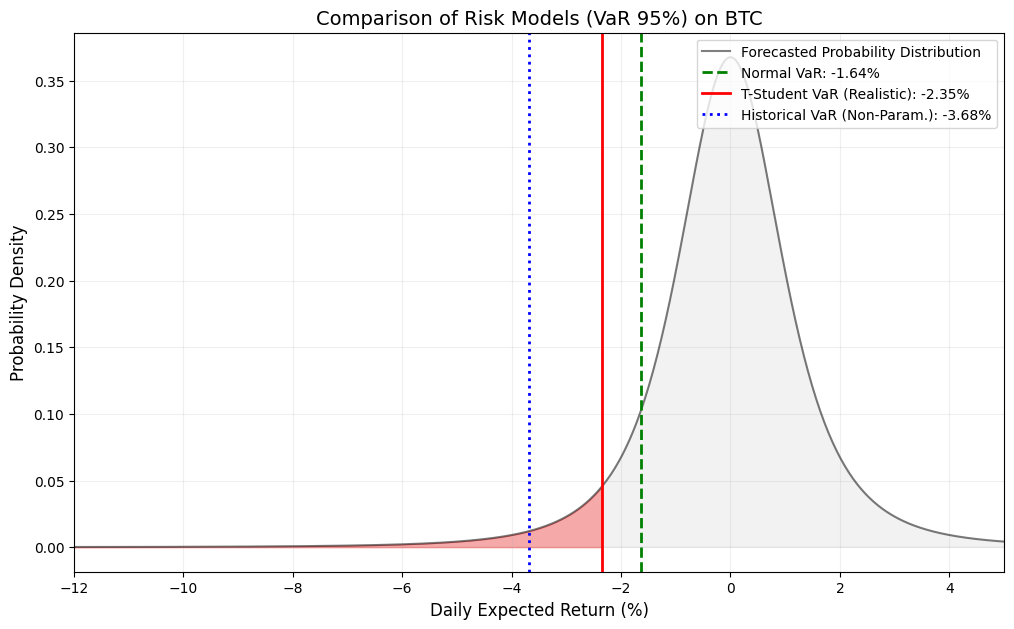

In [8]:
# --- 1. PARAMETER SETTINGS ---
# CORRECTION: Using the variable defined in the previous block (pred_tomorrow)
forecasted_vol = pred_tomorrow
alpha = 0.05  # 95% Confidence
nu = 3        # Degrees of freedom for T-Student (Fat tails, typical for Crypto)

# --- 2. CALCULATION OF THE 3 VaR MODELS ---

# A. NORMAL PARAMETRIC VaR
# Uses standard Z-score (approx 1.645 for 95%)
var_normal = forecasted_vol * abs(norm.ppf(alpha))

# B. T-STUDENT PARAMETRIC VaR
# More conservative: accounts for "black swans" (fat tails)
var_t_student = forecasted_vol * abs(t.ppf(alpha, nu))

# C. NON-PARAMETRIC (HISTORICAL) VaR
# Based exclusively on the actual past distribution
var_historical = abs(np.percentile(df['Returns'], alpha * 100))

# --- 3. PLOT AND VISUALIZATION ---

plt.figure(figsize=(12, 7))

# Simulation distribution for the background
x = np.linspace(-15, 10, 1000)
y = t.pdf(x, df=nu, loc=0, scale=forecasted_vol)
plt.plot(x, y, color='black', alpha=0.5, label='Forecasted Probability Distribution')
plt.fill_between(x, y, color='gray', alpha=0.1)

# Vertical lines for VaR
plt.axvline(-var_normal, color='green', linestyle='--', linewidth=2,
            label=f'Normal VaR: -{var_normal:.2f}%')
plt.axvline(-var_t_student, color='red', linestyle='-', linewidth=2,
            label=f'T-Student VaR (Realistic): -{var_t_student:.2f}%')
plt.axvline(-var_historical, color='blue', linestyle=':', linewidth=2,
            label=f'Historical VaR (Non-Param.): -{var_historical:.2f}%')

# Danger area (Beyond T-Student VaR)
plt.fill_between(x[x < -var_t_student], 0, y[x < -var_t_student], color='red', alpha=0.3)

# Formatting
plt.title(f"Comparison of Risk Models (VaR {1-alpha:.0%}) on BTC", fontsize=14)
plt.xlabel("Daily Expected Return (%)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlim(-12, 5)

plt.show()

In [9]:
# --- 4. TEXT OUTPUT ---
print(f"\n{'VaR MODEL':<25} | {'VALUE':<10}")
print("-" * 40)
print(f"{'Normal Parametric':<25} | -{var_normal:.2f}%")
print(f"{'T-Student Parametric':<25} | -{var_t_student:.2f}%")
print(f"{'Non-Parametric (Historical)':<25} | -{var_historical:.2f}%")


VaR MODEL                 | VALUE     
----------------------------------------
Normal Parametric         | -1.64%
T-Student Parametric      | -2.35%
Non-Parametric (Historical) | -3.68%
